# Machine Learning &mdash; Tutorial2
### Sarah Filippi

## Q2: Linear Discriminant analysis

### b) Downloading the iris the dataset

Consider the iris dataset. The aim is to create a model to predict the species given the input data.


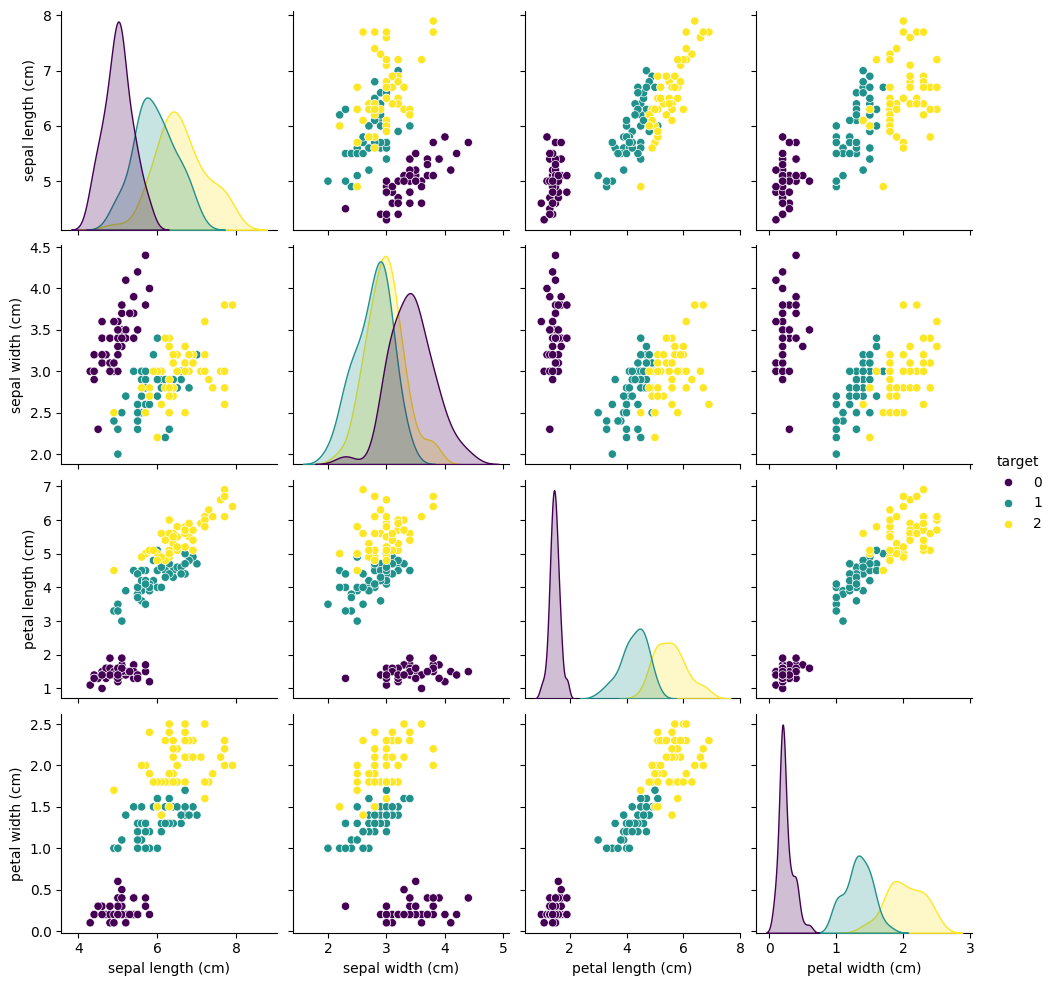

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(122)

iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
iris_df["target"] = iris["target"]

sns.pairplot(data=iris_df, hue="target", palette="viridis")
plt.show()

To simplify the classification task, we will transform the data in order to focus on a binary classification problem: we will classify if a flower is of species Virginica or not.

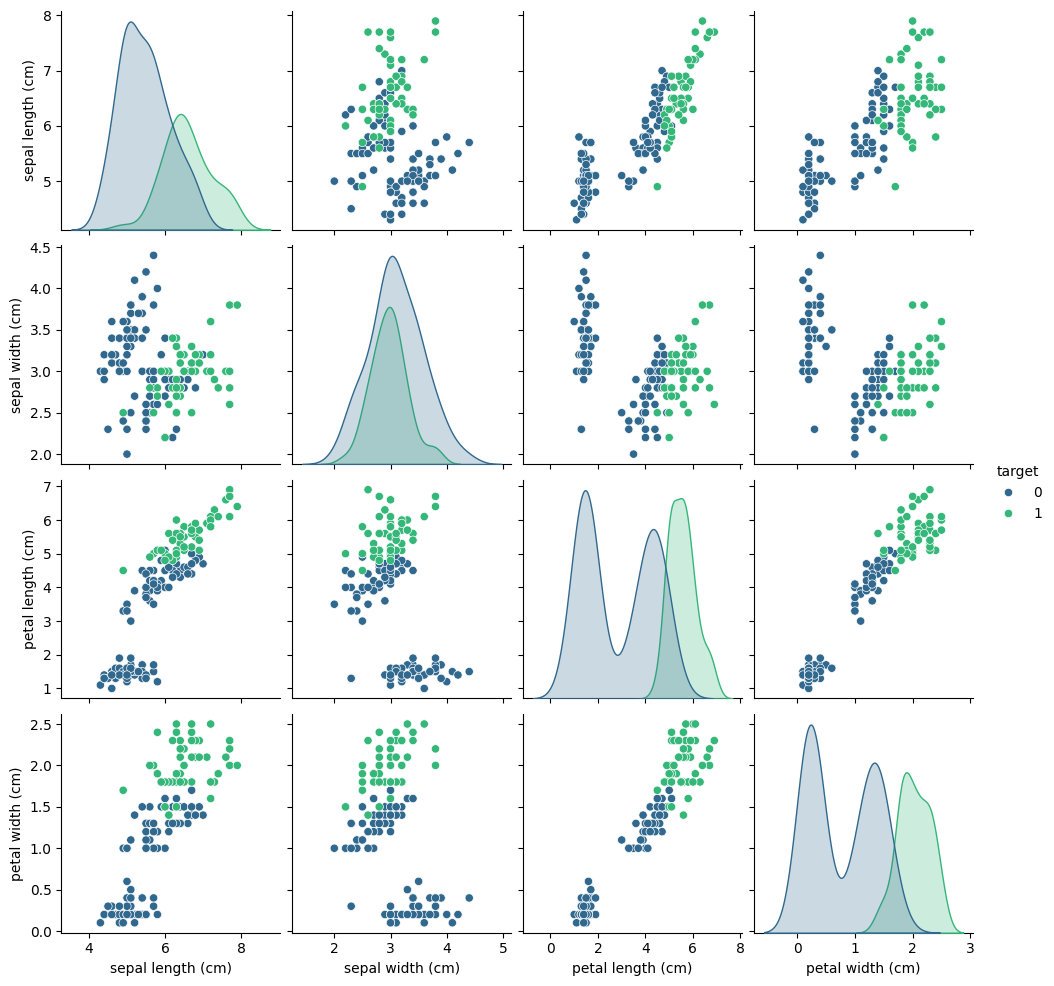

In [3]:
iris_data = iris_df.copy()
iris_data["target"] = np.where(iris_df["target"] == 2, 1, 0)
sns.pairplot(data=iris_data, hue="target", palette="viridis")
plt.show()


### b) Splitting the dataset

We divide the dataset into a training and testing set with a proportion 70\% and 30\%.

In [4]:
training_sample = np.random.choice([True, False], len(iris_data), replace=True, p=(0.7, 0.3))
train_idx = np.where(training_sample == True)[0]
test_idx = np.where(training_sample == False)[0]

x_train, y_train = iris_data.to_numpy()[train_idx, :-1], iris_data.to_numpy()[train_idx, -1]
x_test, y_test = iris_data.to_numpy()[test_idx, :-1], iris_data.to_numpy()[test_idx, -1]

# the package train_test_split could also be used to split the data into training and test sets

### c) Fitting an LDA model

We will first perform the classification task using a Linear Discriminant Analysis. The lda function from the MASS package can be used.

In [5]:
lda = LinearDiscriminantAnalysis()
iris_lda = lda.fit(X=x_train, y=y_train)

In [6]:
print(f"Prior probabilities of groups: \n {iris_lda.priors_} \n")
print(f"Group means: \n {iris_lda.means_} \n")
print(f"Coefficients of linear discriminants: \n {iris_lda.coef_}")

Prior probabilities of groups: 
 [0.66037736 0.33962264] 

Group means: 
 [[5.48571429 3.08571429 2.94       0.81      ]
 [6.61388889 2.99166667 5.57222222 2.04722222]] 

Coefficients of linear discriminants: 
 [[ 0.12934691  1.82071153 -0.98217625  7.99042234]]


To evaluate the prediction accuracy of the LDA model, we first run the model on the training set used to verify the model fits the data properly by using the command predict. The table output is a confusion matrix with the actual species as the row labels and the predicted species at the column labels.

Note that the hard (class) labels are found from predicted probabilities using a threshold of 0.5.

In [8]:
# training set predictions
lda_train = iris_lda.predict(x_train)
print(lda_train)

# test set predictions
lda_test = iris_lda.predict(x_test)
print(lda_test)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]


### d) Model evaluation

Confusion matrices and accuracy are computed using hard (class) labels. ROC curves use predicted probabilities.

#### i) Confusion matrices and accuracy

Confusion matrices for test and train:

In [9]:
cf_train = confusion_matrix(y_train, lda_train)
pd.DataFrame(cf_train, columns=["FALSE", "TRUE"], index=["FALSE", "TRUE"])

,FALSE,TRUE
FALSE,67,3
TRUE,3,33


In [86]:
cf_test = confusion_matrix(y_test, lda_test)
pd.DataFrame(cf_test, columns=["FALSE", "TRUE"], index=["FALSE", "TRUE"])

,FALSE,TRUE
FALSE,28,2
TRUE,2,12


#### ii) ROC curve

We can plot the ROC curve as follows:

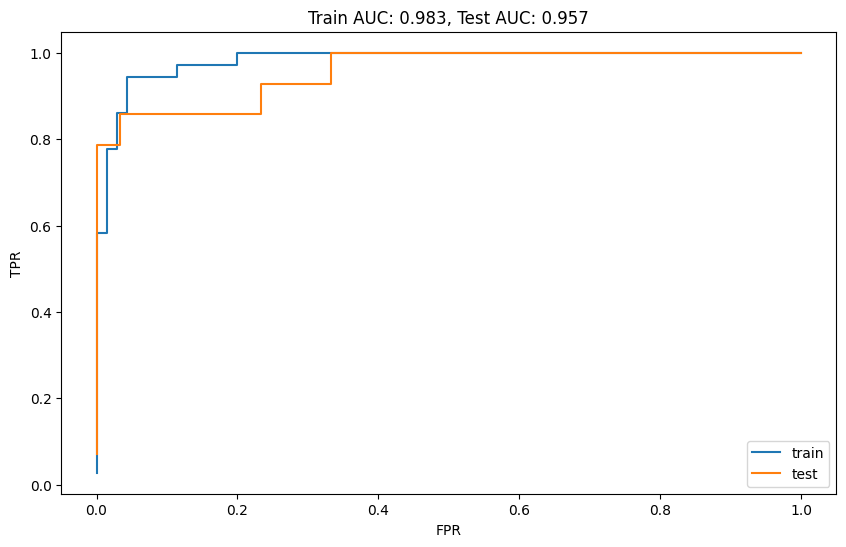

In [10]:
# We create a function to plot the ROC curve
def roc_curve(labels, scores):
    
    idx = np.argsort(scores)[::-1]
    labels = labels[idx]
    
    res = pd.DataFrame()
    
    res["TPR"] = np.cumsum(labels) / np.sum(labels)
    res["FPR"] = np.cumsum(1 - labels) / np.sum(1 - labels)
    
    return res

# We apply this fuction to the training and test sets
train_roc = roc_curve(y_train, lda.predict_proba(x_train)[:, -1])
test_roc = roc_curve(y_test, lda.predict_proba(x_test)[:, -1])

# We compute the AUC by integrating the ROC curve using the composite trapezoidal rule
train_auc = np.trapz(y=train_roc["TPR"], x=train_roc["FPR"])
test_auc = np.trapz(y=test_roc["TPR"], x=test_roc["FPR"])

plt.figure(figsize=(10, 6))
plt.plot(train_roc["FPR"], train_roc["TPR"], label="train")
plt.plot(test_roc["FPR"], test_roc["TPR"], label="test")
plt.title(f"Train AUC: {train_auc:.3}, Test AUC: {test_auc:.3}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

The train AUC is slightly higher than the test AUC, although the difference is small as this is an easy problem.

## Q3: MNIST

## a) Download data and construct an LDA classifier for 0s and 1s

Image datasets often need significant pre-processing. We start by loading the dataset from the .csv file then we split it into X and y. We also convert the pixel intensites (which are in [0.0,255.0] for grayscale images) to [0,1].

In [12]:
# read in the dataset
mnist = pd.read_csv("mnist.csv", header=None)
mnist = mnist.to_numpy()

# split into X and y
X = mnist[:, 1:]
y = mnist[:, 0]

# keep 4s and 9s only - 12,665 examples in total
included_examples = np.isin(y, [4, 9])
X = X[included_examples]
y = y[included_examples]

# convert to [0,1] from grayscale
X = X / 255.0

In [13]:
def make_square(vec):
    image_size = int(np.sqrt(len(vec)))
    tmp = np.reshape(vec, (image_size, image_size))
    return tmp

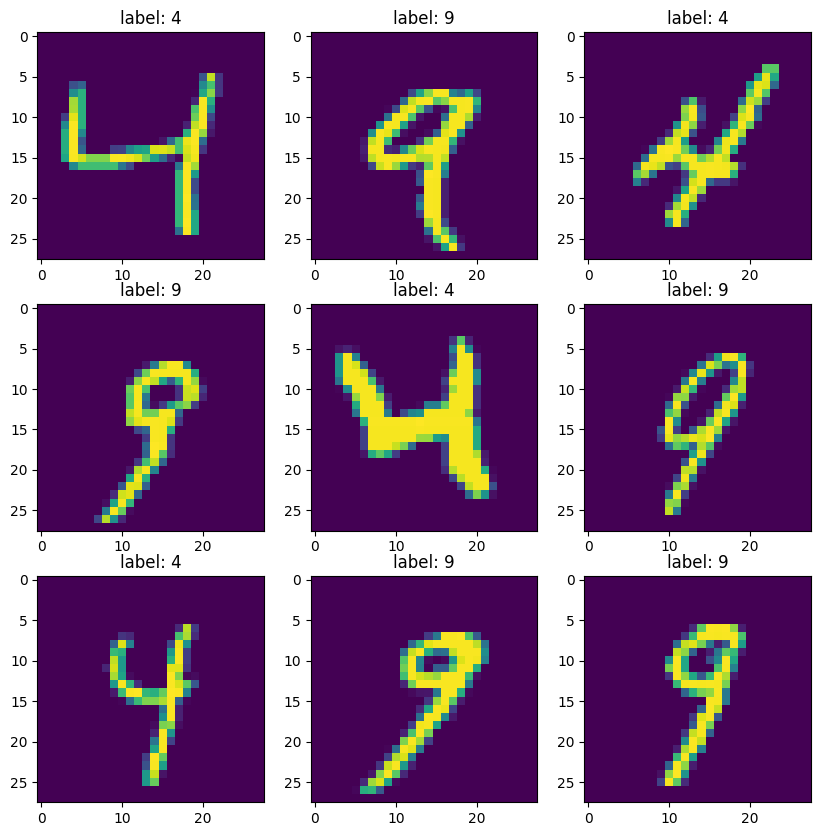

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(make_square(X[3*i + j]))
        ax[i, j].set_title(f"label: {y[3*i + j]}")   

Many of the pixels have zero-variance and so need to be removed (e.g. those at the border, which are zero in every image). We also remove pixels with very small variances as they are likely to be zero-variance in either one of the training or test sets.

In [15]:
X = X[:, np.var(X, axis=0) > 1e-3]

In [16]:
TEST_SIZE = 0.6 # smaller training set to reduce computational cost

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

In [17]:
# Note that different sovers can be used for LDA
lda = LinearDiscriminantAnalysis(solver='svd', tol=1.e-4)
mnist_lda = lda.fit(X=X_train, y=y_train)

## b) Penalised logistic regression

We now consider penalised logistic regression for this classification task. Logistic regression is a generalized linear model (GLM) with logit as the link function and a binomial error model. 

A typical advice when using common regularization techniqeus is to standardize the predictors before fitting the model. Most packaged can do this standardisation for you, but often it is easier to keep track of transformations when you do them yourself. Here we transform the training and test sets separately to avoid data leakage from the training set to the test set. Another option could be to center/scale both datasets using the the means and variances of each variable on the training set.

In [94]:
# standardised versions of training and test sets
scaler = StandardScaler()

X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

### i) Ridge
Here we are using 5-fold CV to select the penalties. Always specify your own sequence of lambda penalties and remember to check that you have found the value that minimises the cross-validation error.

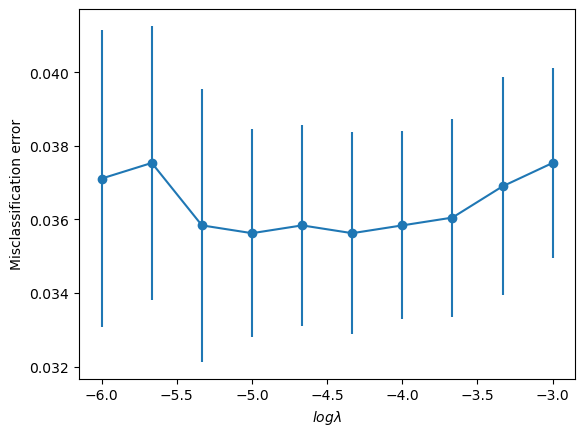

Best C: [0.06294027] Best log lambda: [-5.]


In [95]:
from sklearn.linear_model import LogisticRegressionCV

# train ridge model
lmbdas = np.exp(np.linspace(-6, -3, 10))
# for consistency with regularization in linear model and glmnet in R
# Smaller Cs = larger lambda -> more regularization
Cs = 2/X_train_.shape[0] * 1/lmbdas 
mnist_ridge = LogisticRegressionCV(Cs=Cs, cv=5, scoring='accuracy', penalty='l2', solver='lbfgs', max_iter=10000, tol=1.e-7)
mnist_ridge.fit(X_train_, y_train)

# plots CV error vs lambda
mnist_ridge_scores = mnist_ridge.scores_[9]

plt.errorbar(x=np.linspace(-6, -3, 10), 
             y=1 - mnist_ridge_scores.mean(0), 
             yerr=mnist_ridge_scores.std(0), 
             fmt='-o')
plt.xlabel("$log \lambda$")
plt.ylabel("Misclassification error")
plt.show()

print("Best C:", mnist_ridge.C_, "Best log lambda:", np.log(1/mnist_ridge.C_*2/X_train_.shape[0]))

### ii)  LASSO

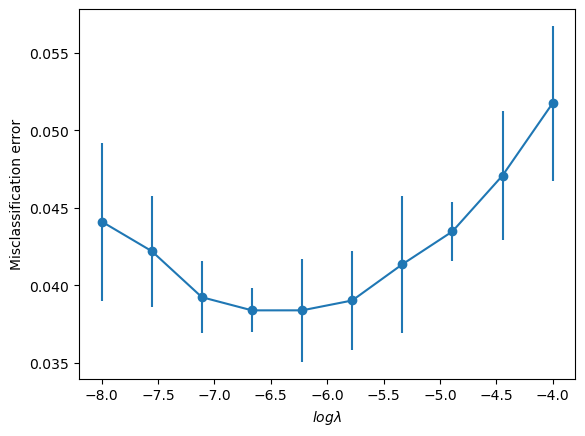

Best C: [0.33323664] Best log lambda: [-6.66666667]


In [96]:
# train lasso model
lmbdas = np.exp(np.linspace(-8, -4, 10))
Cs = 2/X_train_.shape[0] * 1/lmbdas # as above
mnist_lasso = LogisticRegressionCV(Cs=Cs, cv=5, scoring='accuracy', penalty='l1', solver='liblinear', max_iter=10000, tol=1.e-7)
mnist_lasso.fit(X_train_, y_train)

# plots CV error vs lambda
mnist_lasso_scores = mnist_lasso.scores_[9]

plt.errorbar(x=np.linspace(-8, -4, 10), 
             y=1 - mnist_lasso_scores.mean(0), 
             yerr=mnist_lasso_scores.std(0), 
              fmt='-o')
plt.xlabel("$log \lambda$")
plt.ylabel("Misclassification error")
plt.show()

print("Best C:", mnist_lasso.C_, "Best log lambda:", np.log(1/mnist_lasso.C_*2/X_train_.shape[0]))

## c) Model comparison

We compare the models using their predictions on the test set. The table below contains predicted probabilities of each image being being labelled "9". Note that for the ridge and lasso, by default it is using the value of lambda that has minimised the CV error.

In [97]:
test_predictions = pd.DataFrame()

test_predictions["lda"] = mnist_lda.predict_proba(X_test_)[:, -1]
test_predictions["ridge"] = mnist_ridge.predict_proba(X_test_)[:, -1]
test_predictions["lasso"] = mnist_lasso.predict_proba(X_test_)[:, -1]

test_predictions.head()

,lda,ridge,lasso
0,1.041107e-15,0.000001,0.000003
1,1.185320e-10,0.003796,0.003285
2,1.000000e+00,1.000000,1.000000
3,2.159270e-14,0.000502,0.000635
4,9.999948e-01,0.993090,0.997268


We can then compare the three models using ROC curves. Recall that ROC curves are preferable to accuracy as they use the predicted probabilities, while accuracy requires us to use an arbitrary thresholding procedure.



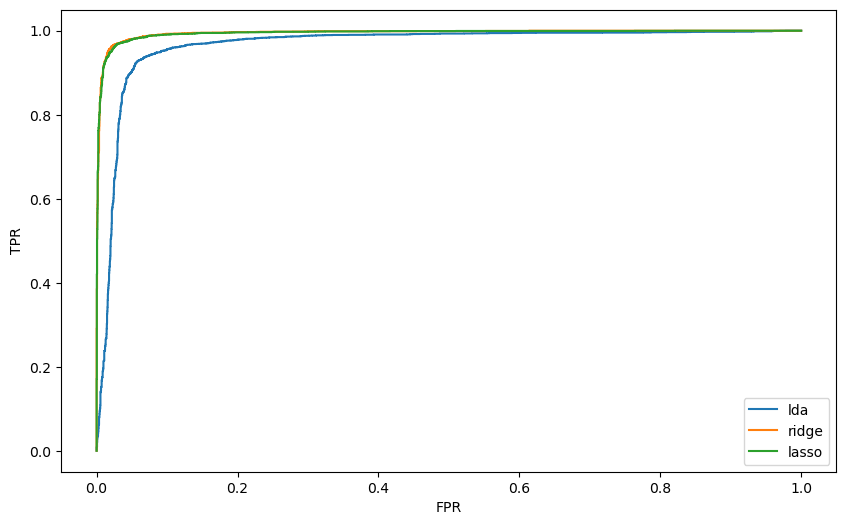

In [98]:
all_roc_curves = {}
for column in test_predictions.columns:
    all_roc_curves[column] = roc_curve(np.where(y_test == 9, 1.0, 0.0), test_predictions[column].values)

plt.figure(figsize=(10, 6))
for model, roc_curve in all_roc_curves.items():
    plt.plot(roc_curve["FPR"], roc_curve["TPR"], label=model)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

We can see immediately that all three models perform very strongly. The corresponding AUCs are

In [99]:
all_auc = {}

for model, _roc_curve in all_roc_curves.items():
    all_auc[model] = np.trapz(y=_roc_curve["TPR"], x=_roc_curve["FPR"])

pd.DataFrame.from_dict(all_auc, orient="index", columns=["AUC"])

,AUC
lda,0.966193
ridge,0.994601
lasso,0.994111


All models have an AUC greater than 0.96, with the penalised linear models performing slightly better. This difference is very small and unlikely to be robust (for example, a different model may have performed better if we had used a different train-test split).

# Q4 -- SPAM detection


We start by exctracting the data from the csv files.

In [17]:
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix

# Read the csv file
messages = pd.read_csv("messages.csv")

# Convert the 'category' column to numeric and subtract 1
y = messages['category'].map({'ham': 0, 'spam': 1})

# Read the matrix file
features = mmread("features.mtx")
# Convert the sparse matrix to a dense matrix
featuresM = csr_matrix(features).todense()


# Get the length of y
N = len(y)

# Get the second dimension of featuresM
nf = featuresM.shape[1]

#print(y.shape)
print(featuresM.shape)


(5572, 7903)


We now split the data split the data into training and test sets with a 80/20 split.

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np
# Set seed
np.random.seed(345)

# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = train_test_split(featuresM, y, test_size=0.2)
print(Train_X.shape)
print(Test_X.shape)
print(Train_Y.shape)
print(Test_Y.shape)



(4457, 7903)
(1115, 7903)
(4457,)
(1115,)


We now define a function that implements a Naive Bayes classifier with either a Bernoulli or Multinomial distribution. Such classifiers are already implemented in the sklearn package but here we write our own function for inferring the model based on the training dataset and predicting the probability of class 0 for instances in the test set.

In [27]:
def NaiveBayes(distribution, alpha, Train_X, Train_Y, Test_X, Test_Y):
     ## Naive Bayes inference and prediction
     ## distribution can take two value: 0 for Bernoulli, 1 for multinomial 
     ## alpha is the hyperparameter for Laplace smoothing
    nf = Train_X.shape[1]
    # Learning the model parameters based on the training dataset

    #summing over rows that are in class 1 or 0, to find the total word counts for each row

    counts1 = np.sum(Train_X[Train_Y==1]!=0, axis=0)
    counts0 = np.sum(Train_X[Train_Y==0]!=0, axis=0)
    #prior probability
    pi1 = np.sum(Train_Y==1)/len(Train_Y)
    #bernoulli
    if distribution==0:
        #these are just MLEs
        theta1 = (counts1+alpha)/(np.sum(Train_Y==1)+2*alpha)
        theta0 = (counts0+alpha)/(np.sum(Train_Y==0)+2*alpha)
    else:
        theta1 = (counts1+alpha)/(np.sum(counts1)+alpha*nf)
        theta0 = (counts0+alpha)/(np.sum(counts0)+alpha*nf)
    # Prediction on the test dataset
    p = np.zeros(len(Test_Y))
    for i in range(len(Test_Y)):
        pred0 = np.log(pi1) + np.sum(np.log(theta1[Test_X[i]!=0])) + np.sum(np.log(1-theta1[Test_X[i]==0]))
        pred1 = np.log(1-pi1) + np.sum(np.log(theta0[Test_X[i]!=0])) + np.sum(np.log(1-theta0[Test_X[i]==0]))
        p[i] = np.exp(pred0)/(np.exp(pred0)+np.exp(pred1))
    return p

We now run the function with the two distributions for alpha=1

In [28]:
# Bernoulli Naive Bayes with alpha=1
clf_bernoulli = NaiveBayes(0, 1, Train_X, Train_Y, Test_X, Test_Y)

# Multinomial Naive Bayes with alpha=1
clf_multinomial = NaiveBayes(1, 1, Train_X, Train_Y, Test_X, Test_Y)

We then compare the prediction of the two classifiers in terms of confusion matrix when using the 0.5 threshold and with ROC curves.

In [29]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix for Bernoulli Naive Bayes: \n", confusion_matrix(Test_Y, np.where(clf_bernoulli < 0.5, 0, 1)))
print("Confusion matrix for Multinomial Naive Bayes: \n", confusion_matrix(Test_Y, np.where(clf_multinomial < 0.5, 0, 1)))


Confusion matrix for Bernoulli Naive Bayes: 
 [[973   3]
 [ 26 113]]
Confusion matrix for Multinomial Naive Bayes: 
 [[956  20]
 [ 14 125]]


For the same threshold we can also compute the accuracy, the precision and the recall.

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve
# Function to calculate accuracy, precision, and recall
def AcPrecRec(pred):
    accuracy = accuracy_score(Test_Y, pred)
    precision = precision_score(Test_Y, pred)
    recall = recall_score(Test_Y, pred)
    return accuracy, precision, recall

print("Accuracy, precision and recall for Bernoulli Naive Bayes: \n", AcPrecRec(np.where(clf_bernoulli < 0.5, 0, 1)))
print("Accuracy, precision and recall for Multinomial Naive Bayes: \n", AcPrecRec(np.where(clf_multinomial < 0.5, 0, 1)))


Accuracy, precision and recall for Bernoulli Naive Bayes: 
 (0.9739910313901345, 0.9741379310344828, 0.8129496402877698)
Accuracy, precision and recall for Multinomial Naive Bayes: 
 (0.9695067264573991, 0.8620689655172413, 0.8992805755395683)


We now compare the ROC curves. 

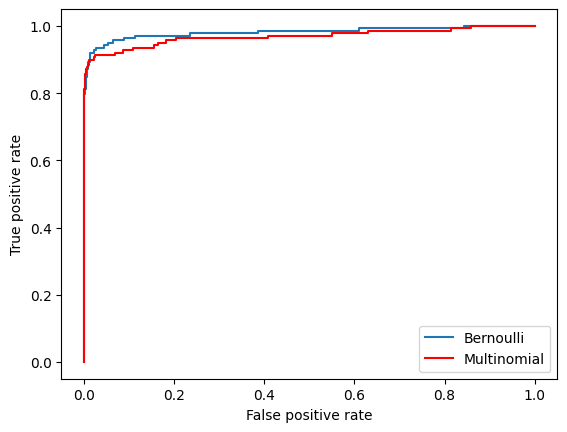

In [32]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# ROC curves
fpr_bernoulli, tpr_bernoulli, _ = roc_curve(Test_Y, clf_bernoulli)
fpr_multi, tpr_multi, _ = roc_curve(Test_Y, clf_multinomial)

plt.plot(fpr_bernoulli, tpr_bernoulli, label='Bernoulli')
plt.plot(fpr_multi, tpr_multi, label='Multinomial', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()